### This notebook shows how to use recurrent neural network for multi-step forecast of power consumption.

In [1]:
import sys
import numpy as np
import pandas as pd

from datetime import timedelta as td
import dateutil.parser

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'])

# sort dataframe
df = df.sort_values(by='Datetime').reset_index(drop=True)

df.head()

,Datetime,EKPC_MW
0,2013-06-01 01:00:00,1166.0
1,2013-06-01 02:00:00,1098.0
2,2013-06-01 03:00:00,1036.0
3,2013-06-01 04:00:00,1023.0
4,2013-06-01 05:00:00,949.0


In [3]:
df.tail()

,Datetime,EKPC_MW
45329,2018-08-02 20:00:00,1815.0
45330,2018-08-02 21:00:00,1769.0
45331,2018-08-02 22:00:00,1756.0
45332,2018-08-02 23:00:00,1619.0
45333,2018-08-03 00:00:00,1448.0


# Explore data

In [4]:
print(df.shape) # shape
print()
print(df.info()) # general info
print()
df.isna().sum() # missing values

(45334, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
Datetime    45334 non-null datetime64[ns]
EKPC_MW     45334 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.4 KB
None



Datetime    0
EKPC_MW     0
dtype: int64

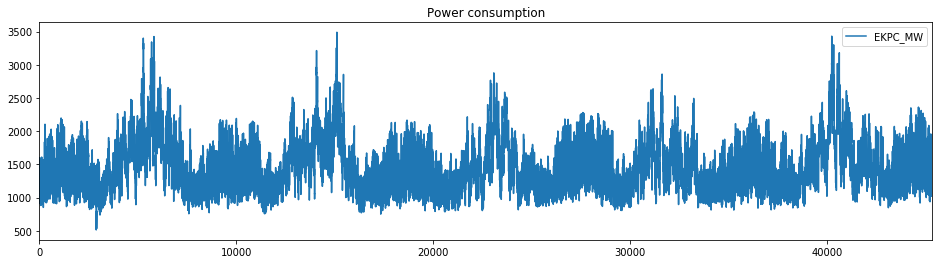

In [5]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Create pipeline

In [6]:
# transformer function to encode calendar data
trans_func = lambda df: np.concatenate([df['Datetime'].apply(lambda x: x.month).values.reshape(-1,1),
                                        df['Datetime'].apply(lambda x: int(x.day/7)).values.reshape(-1,1),
                                        df['Datetime'].apply(lambda x: x.weekday()).values.reshape(-1,1),
                                        df['Datetime'].apply(lambda x: x.hour).values.reshape(-1,1)], axis=1)

# feature transformer pipeline
feature_transformer = make_pipeline(FunctionTransformer(func=trans_func), OneHotEncoder(sparse=False))

# target transformer
target_transformer = MinMaxScaler(feature_range=(-1, 1))

# Split data

In [7]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[df.Datetime < dateutil.parser.parse("2016-01-01")]
df_valid = df[(df.Datetime >= dateutil.parser.parse("2016-01-01")) & (df.Datetime < dateutil.parser.parse("2017-01-01"))]
df_test = df[df.Datetime >= dateutil.parser.parse("2017-01-01")]

# fit transformers on training data and perform transformations creating numpy arrays
# train data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

# validation data
X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

# test data
X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22654, 48) y_train = (22654, 1)
X_valid = (8784, 48) y_valid = (8784, 1)
X_test = (13896, 48) y_test = (13896, 1)


In [8]:
# organize data in a way suitable for tensorflow model
def get_data(x_vals, y_vals, T=24):

    x, y = [], []
    
    for i in range(T, y_vals.shape[0]-T):   
        x_ = x_vals[i,:].reshape(1, -1)
        y_ = y_vals[i-1].reshape(1, -1)
        f = np.concatenate((x_, y_), axis=1)        
        x.append(f)
        
        y.append(y_vals[i:i+T].reshape(-1, 1))
    
    return np.array(x), np.transpose(np.array(y), (1, 0, 2))

# get data sets in numpy arrays
x_train, y_train_np = get_data(X_train, y_train)
x_valid, y_valid_np = get_data(X_valid, y_valid)
x_test, y_test_np = get_data(X_test, y_test)

# print shape of array
print('x_train = {} y_train = {}'.format(x_train.shape, y_train_np.shape))
print('x_valid = {} y_valid = {}'.format(x_valid.shape, y_valid_np.shape))
print('x_test = {} y_test = {}'.format(x_test.shape, y_test_np.shape))

x_train = (22606, 1, 49) y_train = (24, 22606, 1)
x_valid = (8736, 1, 49) y_valid = (24, 8736, 1)
x_test = (13848, 1, 49) y_test = (24, 13848, 1)


# Build tensorflow model

## Architecture: one to sequence model

<!--- 

-->
<img src="images/energy/one2seq_l2.png" width="600" height="400" style="float: center"/>

In [9]:
def build_model(n_x, T):

    # inputs and outputs
    x_input = Input(shape=(1, n_x))
    outputs = [] 
    
    # number of units in each recurrent layer
    num_units = [128, 64]
    
    # init layers
    layers = {}    
    layers['output'] = Dense(1, activation='linear', kernel_regularizer=reg_l2(1e-3))
    layers['input'] = [GRU(num_units[0], return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3)), 
                       GRU(num_units[0], return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3))]    
    layers['recurrent'] = []
    for i, n_units in enumerate(num_units):
        if i == 0:
            l = None # placeholder, it will be input 1 or input 2
        else:
            l = GRU(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3)) # inner            
        layers['recurrent'].append(l)  
                      
    
    # Loop over T and generate a value at every time step
    for t in range(T):
        
        if t == 0:           
            x = x_input
            states = [None] * len(num_units)  
            layers['recurrent'][0] = layers['input'][0]
        else:
            x = RepeatVector(1)(y) 
            layers['recurrent'][0] = layers['input'][1]
            
        # encoding to get hidden states
        for i, layer in enumerate(layers['recurrent']):
            # apply recurrent layer
            x, h = layer(x, initial_state=states[i])
            # store hidden state
            states[i] = h            

        # apply output layer to make prediction
        y = layers['output'](h) 

        # Append the prediction to outputs
        outputs.append(y)
    
    
    # model
    model = Model(inputs=x_input, outputs=outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    return model


# model
model = build_model(n_x=x_train.shape[2], T=24)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 49)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 1, 128), (No 68736       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, 1, 64), (Non 37248       gru[0][0]                        
                                                                 gru_1[0][0]                      
                                                                 gru_2[0][1]                      
                                                                 gru_1[1][0]           

## Train the model

In [ ]:
fname_best_model = 'models/energy/multistep/one2seq/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_model,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train model
history = model.fit(x_train, list(y_train_np), 
                    validation_data=(x_valid, list(y_valid_np)), 
                    epochs=100, shuffle=False, callbacks=callbacks, verbose=0)

# Load the weights with the best error on validation data
model.load_weights(fname_best_model)

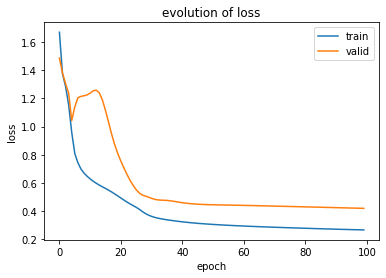

In [11]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [12]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# train data
y_train_true = target_transformer.inverse_transform( y_train_np.squeeze().T )
y_train_pred = target_transformer.inverse_transform( np.squeeze(model.predict(x_train)).T )
print("Train data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = target_transformer.inverse_transform( y_valid_np.squeeze().T )
y_valid_pred = target_transformer.inverse_transform( np.squeeze(model.predict(x_valid)).T )
print("Valid data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = target_transformer.inverse_transform( y_test_np.squeeze().T )
y_test_pred = target_transformer.inverse_transform( np.squeeze(model.predict(x_test)).T )
print("Test data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MAPE=8.5771
Valid data: MAPE=9.5773
Test data: MAPE=9.9098


## Plot individual 24-hour forecasts

In [13]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

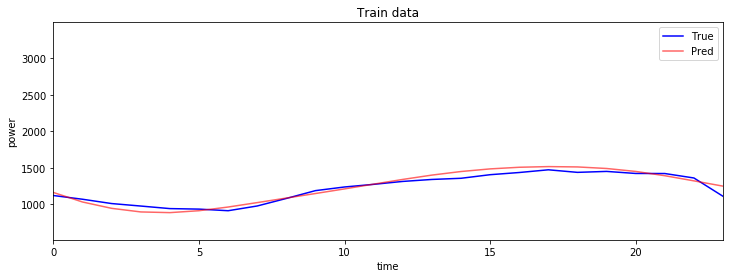

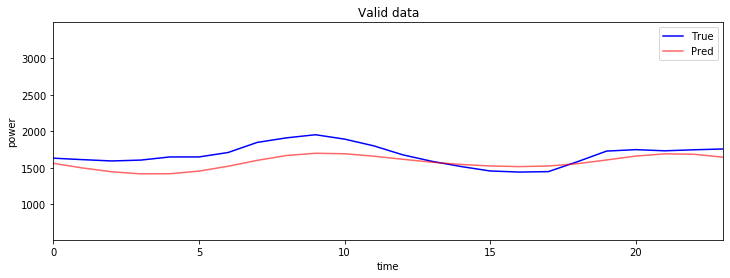

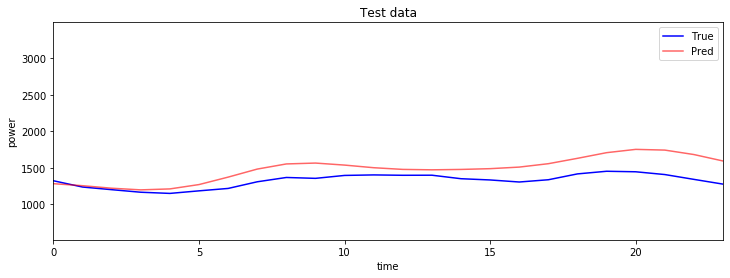

In [14]:
idx = 0 # index of an example in a dataset

# plot train data
plot_predictions(y_train_true[idx,:], y_train_pred[idx,:], "Train data", ylim=ylim)

# plot valid data
plot_predictions(y_valid_true[idx,:], y_valid_pred[idx,:], "Valid data", ylim=ylim)

# plot test data
plot_predictions(y_test_true[idx,:], y_test_pred[idx,:], "Test data", ylim=ylim)

## Plot all 24-hour forecasts concatenating the results 

In [15]:
# concatenate all true values and all predictions

# true values
y_all_train_true = y_train_true.flatten()
y_all_valid_true = y_valid_true.flatten()
y_all_test_true = y_test_true.flatten()

# predicted values
y_all_train_pred = y_train_pred.flatten()
y_all_valid_pred = y_valid_pred.flatten()
y_all_test_pred = y_test_pred.flatten()

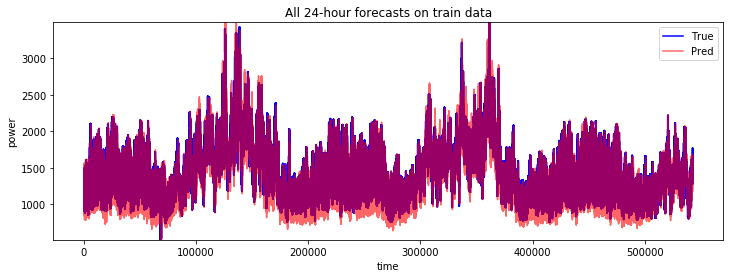

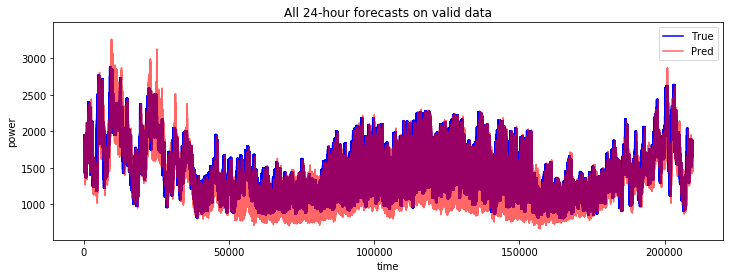

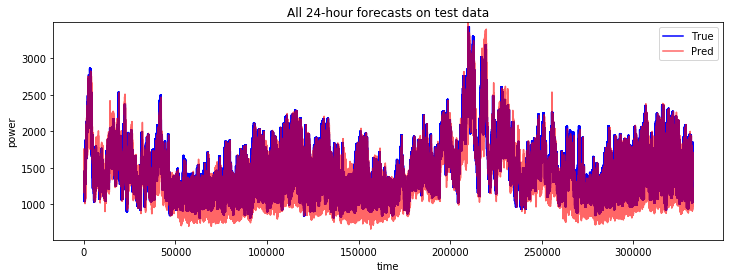

In [16]:
# plot the results
plot_predictions(y_all_train_true, y_all_train_pred, title='All 24-hour forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_all_valid_true, y_all_valid_pred, title='All 24-hour forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_all_test_true, y_all_test_pred, title='All 24-hour forecasts on test data', xlim=None, ylim=ylim)